# Test validity step 2 : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (C^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) (s_c - s_{c,ML})$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import jax
import jax.numpy as jnp
import jax_healpy as jhp
import astropy.io.fits as fits
import camb

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 49152)
(6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


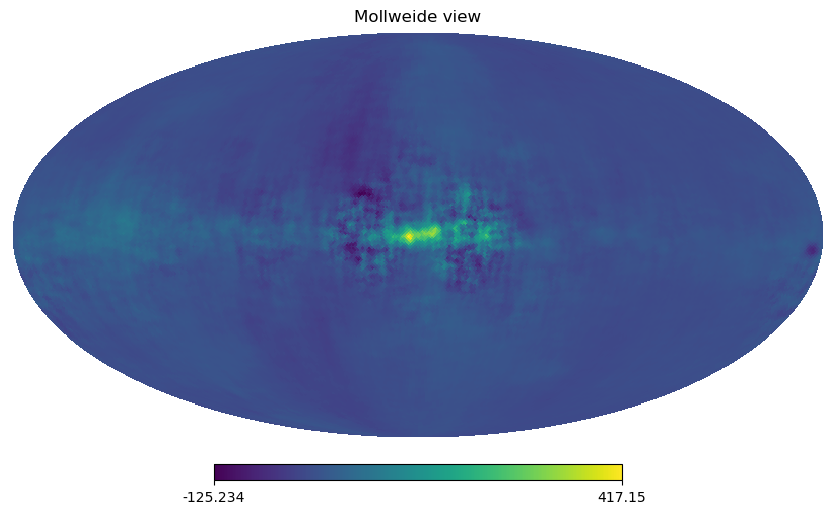

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]),input_cmb_maps[0]])
initial_spectra = hp.anafast(input_cmb_maps_extended, lmax=lmax, iter=n_iter)
initial_spectra[0,:] = 0
initial_spectra[nstokes+2:,:] = 0

c_ells_input = np.zeros((6,lmax+1))
c_ell_approx = np.zeros((6,lmax+1))

c_ells_input[:4,...] = initial_spectra[:4,:]
c_ell_approx[1] = initial_spectra[1,:]
c_ell_approx[2] = initial_spectra[2,:]


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

In [8]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

In [9]:
depth_p = instrument['depth_p']

freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)

init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [10]:
s_cML = jnp.einsum('kc,cf,fsp->ksp', BtinvNB, BtinvN, freq_maps)[0,...]

In [11]:
%%time 

# initial_guess = np.zeros((nstokes,npix))
# map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
# map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
# fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

jax_key = jax.random.PRNGKey(10)

initial_guess = jnp.zeros((nstokes,npix))
map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)

# map_random_realization_xi = jax.random.normal(jax_key, shape=(nstokes,12*nside**2))/jhp.nside2resol(nside)
# map_random_realization_chi = jax.random.normal(jax_key+1, shape=(number_frequencies,nstokes,12*nside**2))/jhp.nside2resol(nside)
# fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
fluctuation_maps_jax = micmac.get_fluctuating_term_maps_JAX(number_frequencies, number_components, nstokes, nside, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, jax_key_PNRG=jax_key, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
CPU times: user 1min 23s, sys: 9.11 s, total: 1min 32s
Wall time: 17.2 s


In [12]:
jiited_get_fluctuating_term_maps_JAX = jax.jit(micmac.get_fluctuating_term_maps_JAX, static_argnames=['number_frequencies', 'nstokes', 'nside', 'lmin', 'n_iter','limit_iter_cg','n_iter'])

In [13]:
%%time
fluctuation_maps_jitted = jiited_get_fluctuating_term_maps_JAX(number_frequencies, number_components, nstokes, nside, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, jax_key_PNRG=jax_key, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
CPU times: user 1min 37s, sys: 7.25 s, total: 1min 44s
Wall time: 34.3 s


In [14]:
%%time
fluctuation_maps_jitted = jiited_get_fluctuating_term_maps_JAX(number_frequencies, number_components, nstokes, nside, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, jax_key_PNRG=jax_key, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CPU times: user 1min 14s, sys: 6.79 s, total: 1min 21s
Wall time: 11.8 s


In [15]:
%%time
fluctuation_maps_jitted = jiited_get_fluctuating_term_maps_JAX(number_frequencies, number_components, nstokes, nside, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, jax_key_PNRG=jax_key, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CPU times: user 1min 15s, sys: 7.05 s, total: 1min 22s
Wall time: 11.9 s


In [16]:

map_random_realization_xi = jax.random.normal(jax_key, shape=(nstokes,12*nside**2))/jhp.nside2resol(nside)
map_random_realization_chi = jax.random.normal(jax_key+1, shape=(number_frequencies,nstokes,12*nside**2))/jhp.nside2resol(nside)
# fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
fluctuation_maps_jitted = jiited_get_fluctuating_term_maps_JAX(number_frequencies, number_components, nstokes, nside, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, jax_key_PNRG=jax_key, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  None iterations !!


In [17]:
fluctuation_maps_jitted = jiited_get_fluctuating_term_maps_JAX(number_frequencies, number_components, nstokes, nside, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, jax_key_PNRG=jax_key, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

In [18]:

map_random_realization_xi = jax.random.normal(jax_key, shape=(nstokes,12*nside**2))/jhp.nside2resol(nside)
map_random_realization_chi = jax.random.normal(jax_key+1, shape=(number_frequencies,nstokes,12*nside**2))/jhp.nside2resol(nside)
# fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
fluctuation_maps_jitted = jiited_get_fluctuating_term_maps_JAX(number_frequencies, number_components, nstokes, nside, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, jax_key_PNRG=jax_key, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

In [19]:
%%time
fluctuation_maps_unJAX = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=[], map_random_realization_chi=[], initial_guess=[], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  492 iterations !!
CPU times: user 1min 17s, sys: 6.88 s, total: 1min 24s
Wall time: 12.4 s


In [20]:
%%time
fluctuation_maps_unJAX = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, BtinvNB, BtinvN_sqrt, map_random_realization_xi=[], map_random_realization_chi=[], initial_guess=[], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  473 iterations !!
CPU times: user 1min 14s, sys: 6.53 s, total: 1min 20s
Wall time: 11.8 s


In [21]:
%%time 
initial_guess = jnp.zeros((nstokes,npix))
# wiener_filter_term = micmac.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, BtinvNB, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
wiener_filter_term_jax = micmac.solve_generalized_wiener_filter_term_JAX(number_frequencies, number_components, nstokes, nside, s_cML, red_cov_matrix, BtinvNB, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  None iterations !!


In [22]:
jitted_solve_generalized_wiener_filter_term_JAX = jax.jit(micmac.solve_generalized_wiener_filter_term_JAX, static_argnames=['number_frequencies', 'nstokes', 'nside', 'lmin', 'n_iter','limit_iter_cg','n_iter'])

In [23]:
%%time 
wiener_filter_term_jitted = jitted_solve_generalized_wiener_filter_term_JAX(number_frequencies, number_components, nstokes, nside, s_cML, red_cov_matrix, BtinvNB, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  None iterations !!
CPU times: user 1min 32s, sys: 10.1 s, total: 1min 42s
Wall time: 17.1 s


In [24]:
%%time
wiener_filter_term = micmac.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, BtinvNB, initial_guess=[], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  586 iterations !!
CPU times: user 1min 33s, sys: 8.9 s, total: 1min 41s
Wall time: 15.2 s


In [25]:
fluctuation_maps = jnp.asarray(fluctuation_maps_jax)
wiener_filter_term = jnp.asarray(wiener_filter_term_jax)

In [26]:
fluctuation_term_extended = np.vstack([np.zeros_like(fluctuation_maps[0]), fluctuation_maps])
wiener_filter_term_extended = np.vstack([np.zeros_like(wiener_filter_term[0]), wiener_filter_term])

c_ells_fluct = hp.anafast(fluctuation_term_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
c_ells_WF = hp.anafast(wiener_filter_term_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [27]:
corr = 1#/hp.nside2resol(nside)

# Analytical Fluctuating Term
covariance_inverse_noise = np.zeros_like(c_ells_input[:,lmin:])
covariance_inverse_noise[:nstokes,...] = np.linalg.pinv(BtinvNB*corr)[0,0]*np.ones_like(c_ells_input)[:nstokes,lmin:]

red_inv_noise = micmac.get_reduced_matrix_from_c_ell(covariance_inverse_noise)

red_inverse_cov_matrix = np.linalg.pinv(red_cov_matrix)
red_inv_cov_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_inverse_cov_matrix)


# First right member : C^{-1/2} \xi
right_member_1 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(map_random_realization_xi, red_inv_cov_sqrt, lmin=lmin, n_iter=n_iter)

## Left hand side term : (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} \chi
right_member_2 = np.einsum('kc,cf,fsp->ksp', BtinvNB, BtinvN_sqrt, map_random_realization_chi)[0] # Selecting CMB component of the random variable

right_member = (right_member_1 + right_member_2)#.ravel()

# Computation of the left side member of the CG

# Left hand side_term inverted and applied to right hand side term : (C^{-1} + N_c^{-1}) right_member
left_member_inverted = np.linalg.pinv(red_inverse_cov_matrix + red_inv_noise*corr)
# left_member_inverted = np.linalg.pinv(red_inverse_cov_matrix + red_inv_noise)
analytical_fluct_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(right_member, left_member_inverted, lmin=lmin, n_iter=n_iter)

In [28]:
corr = 1#/hp.nside2resol(nside)

# Analytical WF Term
# covariance_inverse_noise = np.zeros_like(c_ells_input[:,lmin:])
# covariance_inverse_noise[:nstokes,...] = np.linalg.pinv(BtinvNB*corr)[0,0]*np.ones_like(c_ells_input)[:nstokes,lmin:]


covariance_noise_map = np.random.normal(loc=0, scale=BtinvNB[0,0]/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
covariance_noise_map_extended = np.vstack([np.zeros_like(covariance_noise_map[0]),covariance_noise_map])
covariance_noise = hp.anafast(covariance_noise_map_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
# covariance_inverse_noise[:nstokes,...] = np.linalg.pinv(BtinvNB*corr)[0,0]*np.ones_like(c_ells_input)[:nstokes,lmin:]

red_inv_noise = np.linalg.pinv(micmac.get_reduced_matrix_from_c_ell(covariance_noise))

red_inverse_cov_matrix = np.linalg.pinv(red_cov_matrix)
red_inv_cov_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_inverse_cov_matrix)

# Computation of the right side member of the CG
s_cML_extended = np.zeros((param_dict['number_components'], s_cML.shape[0], s_cML.shape[1]))
s_cML_extended[0,...] = s_cML

right_member = np.einsum('kc,csp->ksp', np.linalg.pinv(BtinvNB), s_cML_extended)[0] # Selecting CMB component of the

# Computation of the left side member of the CG
covariance_inverse_noise_2 = np.zeros_like(c_ells_input[:,lmin:])
covariance_inverse_noise_2[:nstokes,...] = np.linalg.pinv(BtinvNB)[0,0]*np.ones_like(c_ells_input)[:nstokes,lmin:]
red_inv_noise_2 = micmac.get_reduced_matrix_from_c_ell(covariance_inverse_noise_2)

# Left hand side_term inverted and applied to right hand side term : (C^{-1} + N_c^{-1}) right_member
left_member_inverted = np.linalg.pinv(red_inverse_cov_matrix + red_inv_noise_2)
analytical_WF_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(right_member, left_member_inverted, lmin=lmin, n_iter=n_iter)



left_member_inverted_2 = np.einsum('lkm,lmn->lkn', np.linalg.pinv(red_inverse_cov_matrix + red_inv_noise_2), red_inv_noise_2)
analytical_WF_maps_2 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML, left_member_inverted_2, lmin=lmin, n_iter=n_iter)

In [29]:
extended_CG_fluct_maps = np.vstack([np.zeros_like(fluctuation_maps[0]), fluctuation_maps])
extended_CG_WF_maps = np.vstack([np.zeros_like(wiener_filter_term[0]), wiener_filter_term])

extended_analytical_fluct_maps = np.vstack([np.zeros_like(analytical_fluct_maps[0]), analytical_fluct_maps])
extended_analytical_WF_maps = np.vstack([np.zeros_like(analytical_WF_maps[0]), analytical_WF_maps])
extended_analytical_WF_maps_2 = np.vstack([np.zeros_like(analytical_WF_maps[0]), analytical_WF_maps_2])

c_ells_fluct_CG = hp.anafast(extended_CG_fluct_maps, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
c_ells_WF_CG = hp.anafast(extended_CG_WF_maps, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

c_ells_fluct_analytical = hp.anafast(extended_analytical_fluct_maps, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
c_ells_WF_analytical = hp.anafast(extended_analytical_WF_maps, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
c_ells_WF_analytical_2 = hp.anafast(extended_analytical_WF_maps_2, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [30]:
ell_arange = np.arange(c_ells_input.shape[1]) 

In [31]:
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(2)/BtinvNB[0,0])

analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)

analytical_fluct = analytical_WF_harm.copy()
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_fluct)

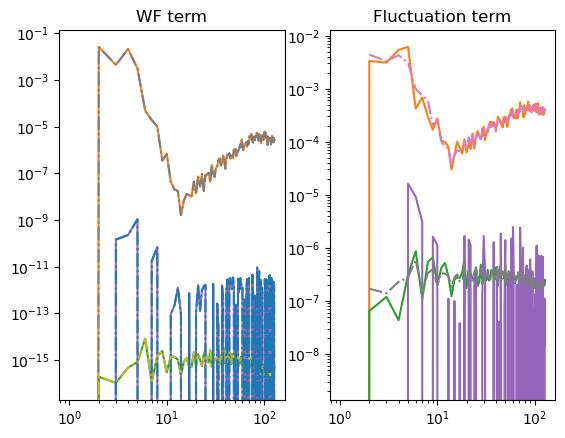

In [32]:
wiener_filter_term_ext = np.vstack([np.zeros_like(wiener_filter_term[0]),wiener_filter_term])
fluctuation_maps_ext = np.vstack([np.zeros_like(fluctuation_maps[0]),fluctuation_maps])

c_ell_WF = hp.anafast(wiener_filter_term_ext, lmax=lmax,iter=n_iter)
c_ell_fluct = hp.anafast(fluctuation_maps_ext, lmax=lmax,iter=n_iter)
plt.subplot(121)
plt.plot(np.arange(c_ell_WF.shape[-1]), c_ell_WF.T)
plt.plot(np.arange(c_ell_WF.shape[-1]), analytical_WF_cells.T, '-.')
plt.loglog()
plt.title('WF term')

plt.subplot(122)
plt.plot(np.arange(c_ell_fluct.shape[-1]), c_ell_fluct.T)
plt.plot(np.arange(lmin,c_ell_fluct.shape[-1]), analytical_fluct_c_ell.T, '-.')

plt.loglog()
plt.title('Fluctuation term')

plt.show()

In [33]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

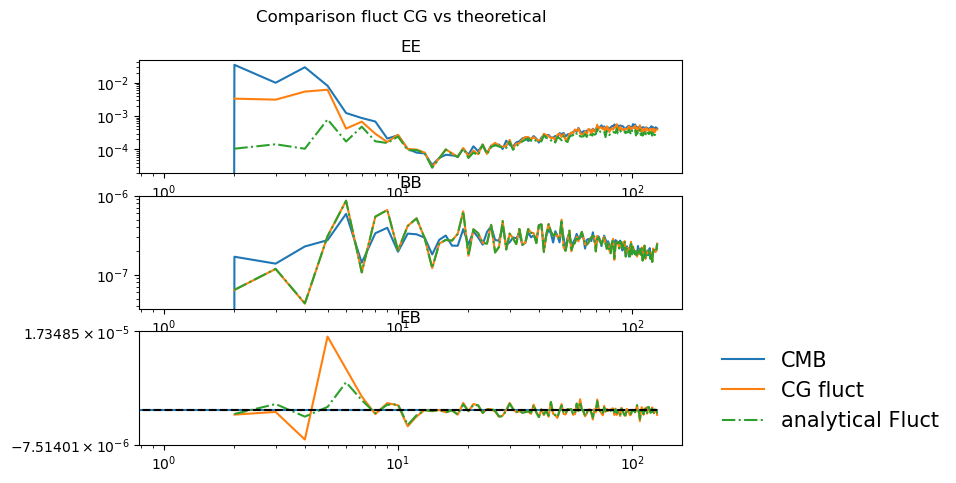

In [34]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']


plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison fluct CG vs theoretical")

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    plt.plot(ell_arange, c_ells_input.T[:,j], label='CMB')
    # plt.plot(ell_arange[lmin:], noise[j,:], label=r"$\eta$ CG")

    plt.plot(ell_arange[lmin:], c_ells_fluct_CG[j,:], label=r"CG fluct")
    
    plt.plot(ell_arange[lmin:], c_ells_fluct_analytical[j,:], '-.', label=r"analytical Fluct")
    
    plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


plt.show()

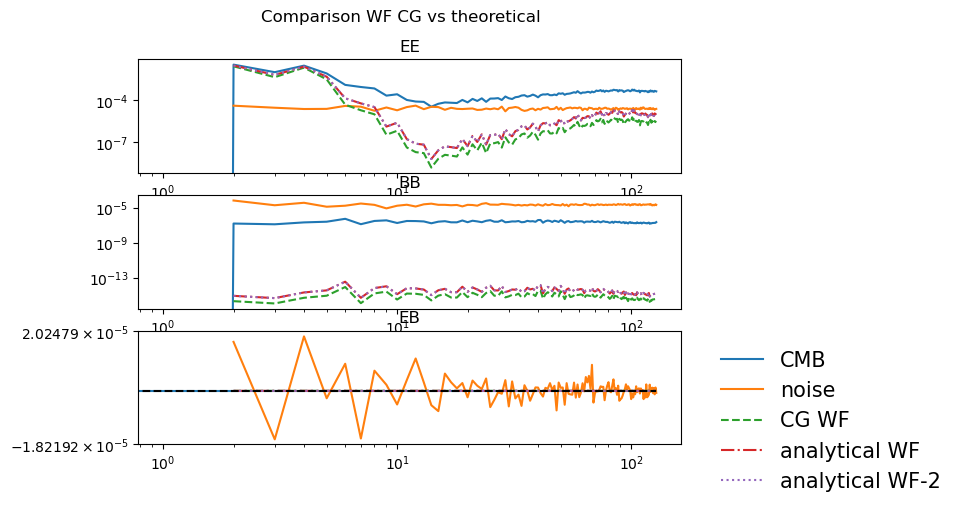

In [35]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']


plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison WF CG vs theoretical")

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    plt.plot(ell_arange, c_ells_input.T[:,j], label='CMB')
    plt.plot(ell_arange[lmin:], covariance_noise.T[:,j], label='noise')
    
    # plt.plot(ell_arange[lmin:], noise[j,:], label=r"$\eta$ CG")

    plt.plot(ell_arange[lmin:], c_ells_WF_CG[j,:], '--', label=r"CG WF")
    
    plt.plot(ell_arange[lmin:], c_ells_WF_analytical[j,:], '-.', label=r"analytical WF")
    plt.plot(ell_arange[lmin:], c_ells_WF_analytical_2[j,:], ':', label=r"analytical WF-2")
    
    plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


plt.show()